In [1]:
%pylab inline
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

torch.set_default_tensor_type('torch.cuda.FloatTensor')

Populating the interactive namespace from numpy and matplotlib


In [2]:
torch.cuda.current_device()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=64,num_workers=1, pin_memory=True)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

## Definicion y entrenamiento CNN

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(32 * 3 * 3, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.relu(self.conv3(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features




net = Net().to(device)
print(net)

import torch.optim as optim

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [5]:

PATH="mnist_cnn.pt"
train_model=False
if train_model:
    net.train()
    losses = []
    for epoch in range(100):
        for batch_idx, (data, target) in enumerate(train_loader):
            # Get Samples
            data, target = Variable(data.cuda()), Variable(target.cuda())
            data=data.to(device)
            target=target.to(device)
            # Init
            optimizer.zero_grad()

            # Predict
            y_pred = net(data) 

            # Calculate loss
            loss = F.cross_entropy(y_pred, target)
            losses.append(loss)
            # Backpropagation
            loss.backward()
            optimizer.step()


            # Display
            if batch_idx % 100 == 1:
                print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, 
                    batch_idx * len(data), 
                    len(train_loader.dataset),

                    100. * batch_idx / len(train_loader), 
                    loss), 
                    end='')
    save_model=True
    if (save_model):
        torch.save(net.state_dict(),PATH)
else:
    net.load_state_dict(torch.load(PATH))
    net.eval()

In [6]:
def test(net,loader, lim=10):
    d=[]
    for batch_idx, (data, target) in enumerate(loader):
        data, target = Variable(data.cuda()), Variable(target.cuda())

        output = net(data )
        pred = output.data.max(1)[1]
        d.extend( pred.eq(target).cpu() )
        if batch_idx>lim:
            continue

    d=np.array(d)
    accuracy = float(np.sum(d) ) / float( d.shape[0])
    return accuracy
    
test(net, test_loader)

0.9884

## Destilacion de logits, MLP 1 capa

In [7]:
import matplotlib as mpl
def plot_exp(exps, one_lay=True):
  mpl.style.use('seaborn')
  c=plt.get_cmap('tab20')
  f, ax = plt.subplots(1, 4, figsize=(30,10))
  terminal=[]
  j=0
  for mod,history in exps.items():
    
    ax[0].plot(history["epoch"],history["train"], label=mod,color=c(j/20))
    ax[1].plot(history["epoch"],history["test"], label=mod,color=c(j/20))
    ax[2].plot(history["epoch"],history["loss"], label=mod,color=c(j/20))
    terminal.append([int(mod),history["train"][-1],history["test"][-1] ] )
    j+=1
    
  ax[1].legend()

  ax[0].set_title("C.E train")
  ax[1].set_title("C.E. test")
  ax[2].set_title("Distillation loss")

  ax[0].set_xlabel("epochs")
  ax[1].set_xlabel("epochs")
  ax[2].set_xlabel("epochs")
  

  ax[0].set_ylabel("C.E. loss")
  ax[1].set_ylabel("C.E. loss")
  ax[2].set_ylabel("Distillaton loss")

  if one_lay:
    ax[3].plot([i[0] for i in terminal],[i[1] for i in terminal], label="Train")
    ax[3].plot([i[0] for i in terminal],[i[2] for i in terminal], label="Test")
    ax[3].plot([i[0] for i in terminal],[i[2]/i[1] for i in terminal], label="test/train")

    ax[3].set_title("terminal values")
    ax[3].set_ylabel("C.E. loss")
    ax[3].set_xlabel("hidden size")

    plt.legend()


In [8]:
def dist_loss_gen(T=8):
  def dist_loss(student_scores,  teacher_scores, T=T):
      return nn.KLDivLoss()(F.log_softmax(student_scores/T,dim=1), F.softmax(teacher_scores/T,dim=1))
  return dist_loss

def sample(loader):
    data,target=next(iter(loader))
    data, target = Variable(data.cuda()), Variable(target.cuda())
    return data,target
  
def dist_model(T_model, S_model, epochs, criterion, eval_criterion, optimizer):
  global train_loader, test_loader
  #train_loader, x_test,y_test = experiment_data()
  history={"epoch":[],
           "train":[],
           "test":[],
           "loss":[],
           "acc_train":[],
           "acc_test":[]
          }
  
  S_model.train()
  T_model.eval()
  
  for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):# 784= 28*28
        x_train, y_train = Variable(data.cuda()), Variable(target.cuda())
        optimizer.zero_grad()
        # Forward pass
        
        # Predecir
        S_y_pred = S_model(x_train.view(-1,784))
        T_y_pred = T_model(x_train)

        # Compute Loss
        loss = criterion(S_y_pred,T_y_pred)
        # Backward pass
        loss.backward()
        optimizer.step()
      
    if epoch % 1 == 0:
        x_train, y_train= sample(train_loader)
        y_pred = S_model(x_train.view(-1,784))
        train_stats = eval_criterion(y_pred, y_train) 
        
        x_test, y_test= sample(test_loader)
        y_pred = S_model(x_test.view(-1,784))
        test_stats = eval_criterion(y_pred.squeeze(), y_test) 
        y_predT = T_model(x_test)
        test_statsT = eval_criterion(y_predT.squeeze(), y_test) 


        history["epoch"].append(epoch)
        history["loss"].append(loss.item())
        history["test"].append(test_stats.item())
        history["train"].append(train_stats.item())
        history["acc_test"].append(test(net, train_loader))
        history["acc_train"].append(test(net, test_loader))
        #print('Epoch {}: train loss: {}, test loss: {}'.format(epoch, loss.item(), test_stats.item()) )

  return history



def distillation_experiment(neuronas, epochs, temp, teacher, experiments=2):
  exps={}
  dist_models={}
  
  for i in neuronas:
    trains=[]
    tests=[]
    losses=[]
    acc_train=[]
    acc_test=[]

    for x in range(experiments):
      print("\r",i,x,end='')
      student_model = linear_model([i]).to(device)
      criterion = dist_loss_gen(temp)
      optimizer = torch.optim.SGD(student_model.parameters(), lr = 0.01)
      eval_criterion = torch.nn.CrossEntropyLoss()

      history=dist_model(teacher, student_model, epochs, criterion, eval_criterion,optimizer)
      trains.append(history["train"])
      tests.append(history["test"])
      losses.append(history["loss"])
      acc_train.append(history["acc_train"])
      acc_test.append(history["acc_test"])


    exps[i] = {"epoch":history["epoch"],
               "train":np.array(trains).mean(axis=0),
               "test":np.array(tests).mean(axis=0),
               "loss":np.array(losses).mean(axis=0),
              "acc_train":np.array(acc_train).mean(axis=0),
              "acc_test":np.array(acc_test).mean(axis=0)
              }
    #models[i] = student_model

  plot_exp(exps)
  return exps


#### entrenamiento

In [ ]:
def linear_model( hidden_size,input_size=784, out_size=10):
  layers=[input_size]+hidden_size+[out_size]
  mod_lays=[]
  for i in range(len(layers)-2):
    mod_lays.append(nn.Linear(layers[i], layers[i+1])) 
    mod_lays.append( torch.nn.ReLU())
  mod_lays.append(nn.Linear(layers[-2], layers[-1]))
    
  return nn.Sequential(*mod_lays)

 1 0

C:\Users\PC\.conda\envs\pytorch-pyro\lib\site-packages\torch\nn\functional.py:1992: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


 512 1

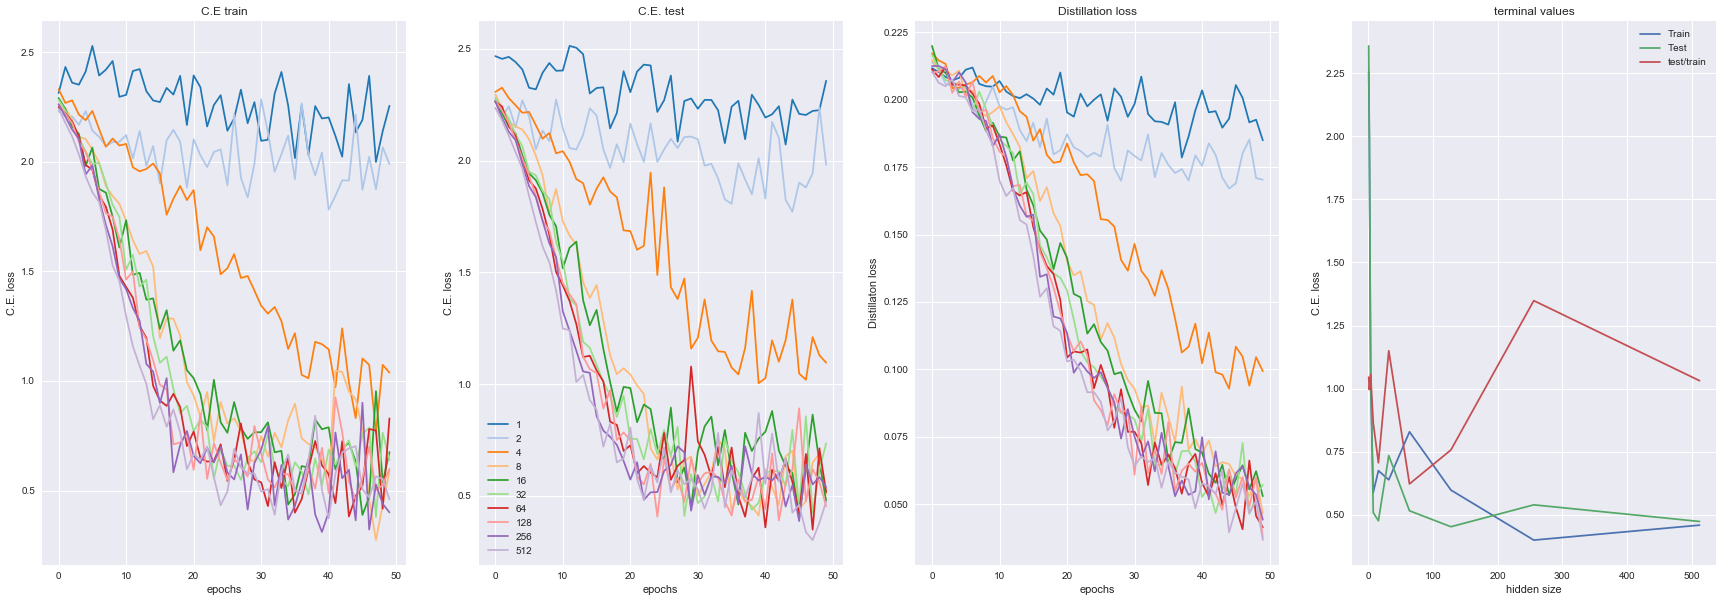

In [ ]:
neuronas=[int(i) for i in np.exp2(np.arange(0,10))]

epochs=50
temp=3.5

teacher=net
for param in teacher.parameters():
    param.requires_grad = False


ex=distillation_experiment(neuronas, epochs, temp, teacher)
p=pd.DataFrame.from_dict(ex)

with open("expDist%f.csv"%temp, "w") as text_file:
    text_file.write(p.to_csv(index=False))

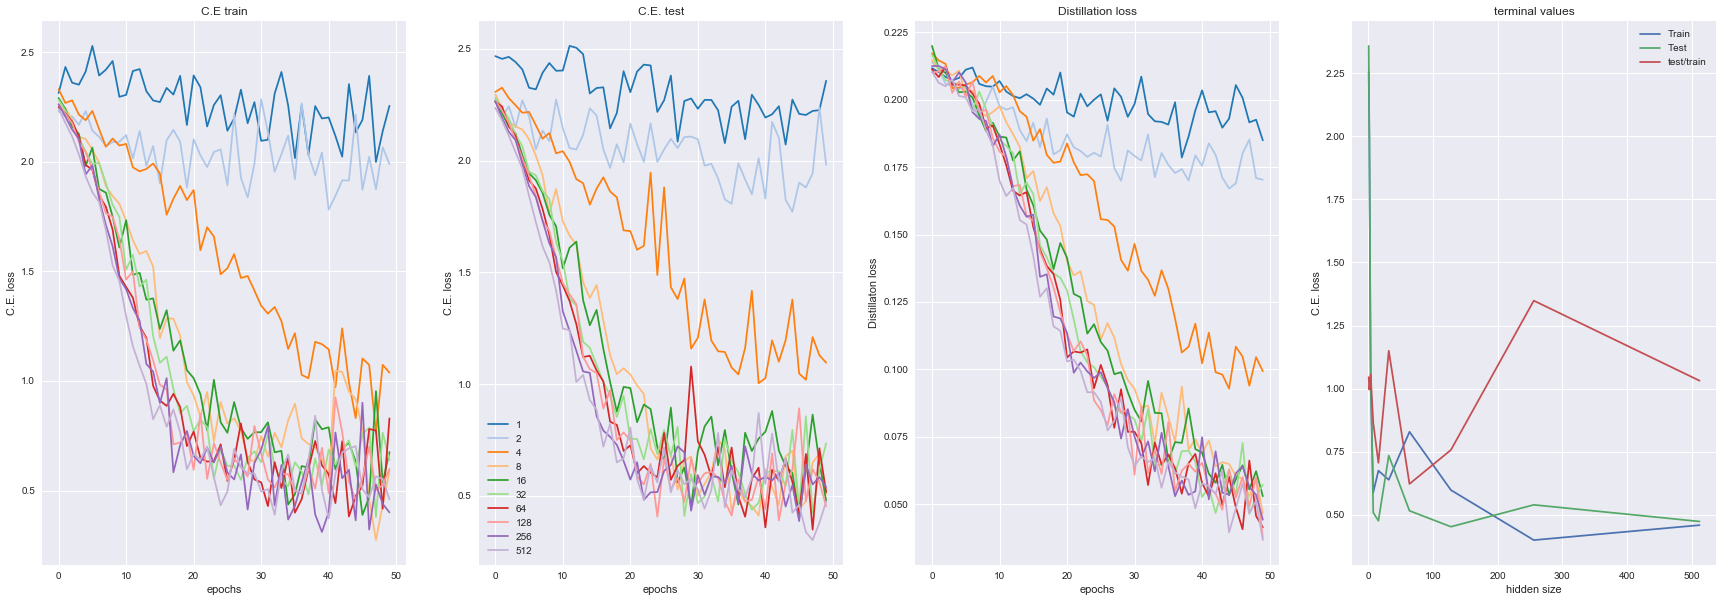

In [ ]:

plot_exp(ex)

In [ ]:
import pandas as pd

p=pd.DataFrame.from_dict(ex)

with open("expDist%f.csv"%temp, "w") as text_file:
    text_file.write(p.to_csv(index=False))


## Con CrossEntropy

In [ ]:
def composed_loss(alpha=0.5, T=8):
  def total_loss(student_scores, teacher_scores,y, alpha=alpha, T=T):
    KD_loss = nn.KLDivLoss()(F.log_softmax(student_scores/T, dim=1),
                             F.softmax(teacher_scores/T, dim=1))
    
  
    CE_loss=nn.CrossEntropyLoss()(student_scores.squeeze(), y) 

    return CE_loss*alpha*temp*temp + KD_loss*(1-alpha)

  return total_loss
  
def sample(loader):
    data,target=next(iter(loader))
    data, target = Variable(data.cuda()), Variable(target.cuda())
    return data,target

def dist_model(T_model, S_model, epochs, criterion, eval_criterion, optimizer):
  global train_loader, test_loader
  #train_loader, x_test,y_test = experiment_data()
  history={"epoch":[],
           "train":[],
           "test":[],
           "loss":[],
           "acc_train":[],
           "acc_test":[]
          }
  
  S_model.train()
  T_model.eval()
  
  for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):# 784= 28*28
        x_train, y_train = Variable(data.cuda()), Variable(target.cuda())
        optimizer.zero_grad()
        # Forward pass
        
        # Predecir
        S_y_pred = S_model(x_train.view(-1,784))
        T_y_pred = T_model(x_train)

        # Compute Loss
        loss = criterion(S_y_pred,T_y_pred)
        # Backward pass
        loss.backward()
        optimizer.step()
      
    if epoch % 1 == 0:
        x_train, y_train= sample(train_loader)
        y_pred = S_model(x_train.view(-1,784))
        train_stats = eval_criterion(y_pred, y_train) 
        
        x_test, y_test= sample(test_loader)
        y_pred = S_model(x_test.view(-1,784))
        test_stats = eval_criterion(y_pred.squeeze(), y_test) 
        y_predT = T_model(x_test)
        test_statsT = eval_criterion(y_predT.squeeze(), y_test) 


        history["epoch"].append(epoch)
        history["loss"].append(loss.item())
        history["test"].append(test_stats.item())
        history["train"].append(train_stats.item())
        history["acc_test"].append(test(net, train_loader))
        history["acc_train"].append(test(net, test_loader))
        #print('Epoch {}: train loss: {}, test loss: {}'.format(epoch, loss.item(), test_stats.item()) )

  return history

def distillation_experiment(neuronas, epochs, temp, teacher, experiments=5):
  exps={}
  dist_models={}
  
  for i in neuronas:
    trains=[]
    tests=[]
    losses=[]
    acc_train=[]
    acc_test=[]
    
    for x in range(experiments):
      print("\r",i,x,end='')
      student_model = linear_model([i]).to(device)
      criterion = dist_loss_gen(temp)
      optimizer = torch.optim.SGD(student_model.parameters(), lr = 0.01)
      eval_criterion = torch.nn.CrossEntropyLoss()

      history=dist_model(teacher, student_model, epochs, criterion, eval_criterion,optimizer)
      trains.append(history["train"])
      tests.append(history["test"])
      losses.append(history["loss"])
      acc_train.append(history["acc_train"])
      acc_test.append(history["acc_test"])

    exps[i] = {"epoch":history["epoch"],
               "train":np.array(trains).mean(axis=0),
               "test":np.array(tests).mean(axis=0),
               "loss":np.array(losses).mean(axis=0),
               "acc_train":np.array(acc_train).mean(axis=0),
              "acc_test":np.array(acc_test).mean(axis=0)}
    #models[i] = student_model

  plot_exp(exps)
  return exps

In [ ]:
neuronas=[int(i) for i in np.exp2(np.arange(0,10))]

epochs=50
temp=3.5

teacher=net
for param in teacher.parameters():
    param.requires_grad = False


ex=distillation_experiment(neuronas, epochs, temp, teacher)
p=pd.DataFrame.from_dict(ex)

with open("expDist%f.csv"%temp, "w") as text_file:
    text_file.write(p.to_csv(index=False))

 1 0

C:\Users\PC\.conda\envs\pytorch-pyro\lib\site-packages\torch\nn\functional.py:1992: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


 2 4

## Destilacion de features, MLP 1 capa